Upload Images

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test64.zip to test64.zip


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train64.zip to train64.zip


In [ ]:
!unzip train64.zip

Archive:  train64.zip
   creating: train64/
   creating: train64/yin_yang64/
  inflating: train64/yin_yang64/image_0021.jpg  
  inflating: train64/yin_yang64/image_0027.jpg  
  inflating: train64/yin_yang64/image_0025.jpg  
  inflating: train64/yin_yang64/image_0028.jpg  
  inflating: train64/yin_yang64/image_0040.jpg  
  inflating: train64/yin_yang64/image_0055.jpg  
  inflating: train64/yin_yang64/image_0052.jpg  
  inflating: train64/yin_yang64/image_0047.jpg  
  inflating: train64/yin_yang64/image_0038.jpg  
  inflating: train64/yin_yang64/image_0026.jpg  
  inflating: train64/yin_yang64/image_0048.jpg  
  inflating: train64/yin_yang64/image_0050.jpg  
  inflating: train64/yin_yang64/image_0058.jpg  
  inflating: train64/yin_yang64/image_0020.jpg  
  inflating: train64/yin_yang64/image_0019.jpg  
  inflating: train64/yin_yang64/image_0049.jpg  
  inflating: train64/yin_yang64/image_0046.jpg  
  inflating: train64/yin_yang64/image_0060.jpg  
  inflating: train64/yin_yang64/image_005

In [ ]:
!unzip test64.zip

Archive:  test64.zip
   creating: test64/
   creating: test64/car_side64/
  inflating: test64/car_side64/image_0010.jpg  
  inflating: test64/car_side64/image_0021.jpg  
  inflating: test64/car_side64/image_0027.jpg  
  inflating: test64/car_side64/image_0025.jpg  
  inflating: test64/car_side64/image_0028.jpg  
  inflating: test64/car_side64/image_0040.jpg  
  inflating: test64/car_side64/image_0006.jpg  
  inflating: test64/car_side64/image_0038.jpg  
  inflating: test64/car_side64/image_0026.jpg  
  inflating: test64/car_side64/image_0020.jpg  
  inflating: test64/car_side64/image_0019.jpg  
  inflating: test64/car_side64/image_0014.jpg  
  inflating: test64/car_side64/image_0012.jpg  
  inflating: test64/car_side64/image_0002.jpg  
  inflating: test64/car_side64/image_0029.jpg  
  inflating: test64/car_side64/image_0030.jpg  
  inflating: test64/car_side64/image_0017.jpg  
  inflating: test64/car_side64/image_0031.jpg  
  inflating: test64/car_side64/image_0016.jpg  
  inflating: t

MY MODEL



Transform Images as S1C1 dataset

In [10]:

class S1C1Transform:
    def __init__(self, filter, pooling_size, pooling_stride, lateral_inhibition = None, timesteps = 15,
          feature_wise_inhibition=True):
      self.grayscale = transforms.Grayscale()
      self.to_tensor = transforms.ToTensor()
      self.filter = filter
      self.pooling_size = pooling_size
      self.pooling_stride = pooling_stride
      self.lateral_inhibition = lateral_inhibition
      self.temporal_transform = Intensity2Latency(timesteps)
      self.feature_wise_inhibition = feature_wise_inhibition

    def S1(self, image):
      """Layer for applying Gabor Filter"""
      image = self.filter(image)
      return image 

    def C1(self, image):
      """Pooling Layer"""
      image = sfpooling(image, self.pooling_size, self.pooling_stride, padding=self.pooling_size//2)
      return image

    def __call__(self, image):
      image = self.to_tensor(self.grayscale(image))
      image.unsqueeze_(0)
      image = self.S1(image)
      image = self.C1(image)
      if self.lateral_inhibition is not None:
        image = self.lateral_inhibition(image)
      temporal_image = self.temporal_transform(image)
      temporal_image = sfpointwise_inhibition(temporal_image)
      return temporal_image.sign().byte()

kernels = [	GaborKernel(5, 45+22.5),
			      GaborKernel(5, 90+22.5),
			      GaborKernel(5, 135+22.5),
			      GaborKernel(5, 180+22.5)]

filter =  Filter(kernels, use_abs = True)


Data Loading

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from torch.utils.data import SubsetRandomSampler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import random
s1c1 = S1C1Transform(filter, 7, 6)

"""Applying S1 and C1 on all of the Images in Image Folder"""

trainsetfolder = CacheDataset(ImageFolder("train64", s1c1))
testsetfolder = CacheDataset(ImageFolder("test64", s1c1))
train_loader = DataLoader(trainsetfolder, batch_size = len(trainsetfolder), shuffle = True)
test_loader = DataLoader(testsetfolder, batch_size = len(testsetfolder), shuffle = True)


Model

In [12]:
class CNV(nn.Module):
  def __init__(self, input_channels, features_per_class, number_of_classes, s2_kernel_size, threshold, stdp_learning_rate, anti_stdp_learning_rate):
      super(CNV, self).__init__()
      self.features_per_class = features_per_class
      self.number_of_classes = number_of_classes
      self.number_of_features = features_per_class * number_of_classes
      self.kernel_size = s2_kernel_size
      self.threshold = threshold
      self.stdp_lr = stdp_learning_rate
      self.anti_stdp_lr = anti_stdp_learning_rate

      self.input_spikes = None
      self.potentials = None
      self.output_spikes = None
      self.winners = None

      self.s2 = Convolution(input_channels, self.number_of_features, self.kernel_size, 0.8, 0.05)
      self.stdp = STDP(self.s2, stdp_learning_rate)
      self.anti_stdp = STDP(self.s2, anti_stdp_learning_rate)
      self.decision_map = []
      for i in range(number_of_classes):
        self.decision_map.extend([i]*features_per_class)
    
  def forward(self, input):
    input = input.float()
    pot = self.s2(input)
    # print(pot.size())
    spk, pot = sffire(pot, self.threshold, True)
    winners = sfget_k_winners(pot,  1, 0, spk)
    output = -1
    if len(winners) != 0:
      output = self.decision_map[winners[0][0]]

    if self.training:
      self.input_spikes = input
      self.potentials = pot
      self.output_spikes = spk
      self.winners = winners
    else:
      self.input_spikes = None
      self.potentials = None
      self.output_spikes = None
      self.winners = None
    return output, pot


  def reward(self):
    self.stdp(self.input_spikes, self.potentials, self.output_spikes, self.winners)

  def punish(self):
    self.anti_stdp(self.input_spikes, self.potentials, self.output_spikes, self.winners)
  



Run The Model

Streaming output truncated to the last 5000 lines.
   Best Train: [ 0.96498054  0.03501946  0.         15.        ]
[[40  0  0  0]
 [ 0 34  2  0]
 [ 0  0 24  0]
 [ 1  1  0 14]]
 Current Test: [0.96551724 0.03448276 0.        ]
    Best Test: [ 0.96551724  0.03448276  0.         15.        ]
Epoch #: 16
[[83  0  0  0]
 [ 3 75  0  0]
 [ 1  1 50  0]
 [ 2  2  0 40]]
Current Train: [0.96498054 0.03501946 0.        ]
   Best Train: [ 0.96498054  0.03501946  0.         16.        ]
[[40  0  0  0]
 [ 0 34  2  0]
 [ 0  0 24  0]
 [ 1  1  0 14]]
 Current Test: [0.96551724 0.03448276 0.        ]
    Best Test: [ 0.96551724  0.03448276  0.         16.        ]
Epoch #: 17
[[83  0  0  0]
 [ 3 75  0  0]
 [ 2  0 50  0]
 [ 1  2  1 40]]
Current Train: [0.96498054 0.03501946 0.        ]
   Best Train: [ 0.96498054  0.03501946  0.         17.        ]
[[40  0  0  0]
 [ 0 34  2  0]
 [ 0  0 24  0]
 [ 1  1  0 14]]
 Current Test: [0.96551724 0.03448276 0.        ]
    Best Test: [ 0.96551724  0.03448276  0.  

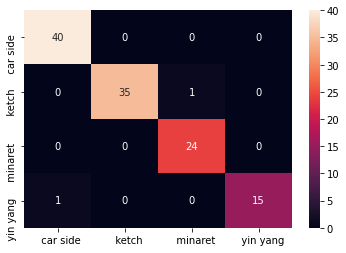

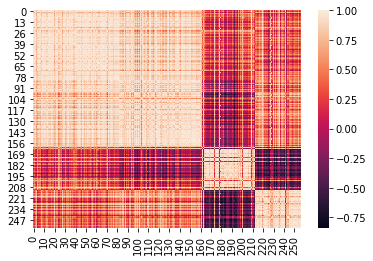

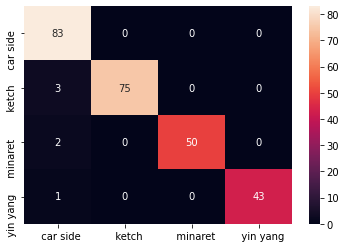

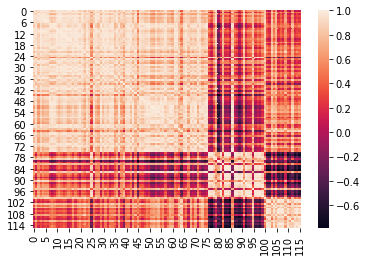

In [17]:
import scipy.stats
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# mymodel = CNV(4, 5, 4, (10, 10), 40, (0.05, -0.0035), (-0.05, 0.0005))
mymodel = CNV(4, 5, 4, (10, 10), 40, (0.05, -0.00125), (-0.05, 0.00015))
import numpy as np
max_epoch = 400

# perf
best_train = np.array([0,0,0,0]) # correct, wrong, silence, epoch
best_test = np.array([0,0,0,0]) # correct, wrong, silence, epoch

# train one batch (here a batch contains all data so it is an epoch)
def train(data, target, network):
	network.train()
	perf = np.array([0,0,0]) # correct, wrong, silence
	target_0 = np.array([0, 0, 0, 0])
	target_1 = np.array([0, 0, 0, 0])
	target_2 = np.array([0, 0, 0, 0])
	target_3 = np.array([0, 0, 0, 0])
	dis_mat = []
	for i in range(len(data)):
		data_in = data[i]
		target_in = target[i]
		d, pot = network(data_in)
		pair = []
		pair.append(target[i].reshape(-1).cpu().numpy()[0])
		pair.append(list(pot.reshape(-1).cpu().numpy()[-20:]))
		dis_mat.append(pair)
		if d != -1:
			if d == target_in:
				perf[0]+=1
				network.reward()
			else:
				perf[1]+=1
				network.punish()
			if target_in == 0:
					target_0[d] += 1
			elif target_in == 1:
					target_1[d] += 1
			elif target_in == 2:
					target_2[d] += 1
			elif target_in == 3:
					target_3[d] += 1
		else:
			perf[2]+=1
	dis_mat = np.matrix(dis_mat)
	dis_mat = dis_mat[np.argsort(dis_mat.A[:, 0])].tolist()
	confusion_matrix = []
	confusion_matrix.append(target_0)
	confusion_matrix.append(target_1)
	confusion_matrix.append(target_2)
	confusion_matrix.append(target_3)
	confusion_matrix = np.array(confusion_matrix)
	print(confusion_matrix)
	return perf/len(data), confusion_matrix, dis_mat

# test one batch (here a batch contains all data so it is an epoch)
def test(data, target, network):
	network.eval()
	perf = np.array([0,0,0]) # correct, wrong, silence
	target_0 = np.array([0, 0, 0, 0])
	target_1 = np.array([0, 0, 0, 0])
	target_2 = np.array([0, 0, 0, 0])
	target_3 = np.array([0, 0, 0, 0])
	dis_mat = []
	for i in range(len(data)):
		data_in = data[i]
		target_in = target[i]
		d, pot = network(data_in)
		pair = []
		pair.append(target[i].reshape(-1).cpu().numpy()[0])
		pair.append(list(pot.reshape(-1).cpu().numpy()[-20:]))
		dis_mat.append(pair)
		if d != -1:
			if d == target_in:
				perf[0]+=1
			else:
				perf[1]+=1
		if target_in == 0:
				target_0[d] += 1
		elif target_in == 1:
				target_1[d] += 1
		elif target_in == 2:
				target_2[d] += 1
		elif target_in == 3:
				target_3[d] += 1
		else:
			perf[2]+=1
	

	dis_mat = np.matrix(dis_mat)
	dis_mat = dis_mat[np.argsort(dis_mat.A[:, 0])].tolist()
	confusion_matrix = []
	confusion_matrix.append(target_0)
	confusion_matrix.append(target_1)
	confusion_matrix.append(target_2)
	confusion_matrix.append(target_3)
	confusion_matrix = np.array(confusion_matrix)
	print(confusion_matrix)
	return perf/len(data), confusion_matrix, dis_mat
	
confusion_matrix_train = []
confusion_matrix = []
for epoch in range(max_epoch):
	print("Epoch #:", epoch)
	for data, target in train_loader:
		perf_train, conf1, dis_mat = train(data, target, mymodel)
	if best_train[0] <= perf_train[0]:
		best_train = np.append(perf_train, epoch)
		confusion_matrix_train = conf1

	print("Current Train:", perf_train)
	print("   Best Train:", best_train)
	for data_test, target_test in test_loader:
		perf_test, con, dis_mat_ = test(data_test, target_test, mymodel)
	if best_test[0] <= perf_test[0]:
		best_test = np.append(perf_test, epoch)
		confusion_matrix = con
	print(" Current Test:", perf_test)
	print("    Best Test:", best_test)





sn.heatmap(confusion_matrix, annot=True, xticklabels=['  car side', '   ketch', '   minaret', '   yin yang'], yticklabels=['   car side', '   ketch', '  minaret', '  yin yang'])
plt.show()

dis_matrix = []
for i in range(len(dis_mat)):
	dis = []
	for j in range(len(dis_mat)):
		dis.append(scipy.stats.pearsonr(dis_mat[i][1], dis_mat[j][1])[0] )
	dis_matrix.append(dis)
sn.heatmap(dis_matrix, annot=False)
plt.show()




sn.heatmap(confusion_matrix_train, annot=True, xticklabels=['  car side', '   ketch', '   minaret', '   yin yang'], yticklabels=['   car side', '   ketch', '  minaret', '  yin yang'])
plt.show()

dis_matrix = []
for i in range(len(dis_mat_)):
	dis = []
	for j in range(len(dis_mat_)):
		dis.append(scipy.stats.pearsonr(dis_mat_[i][1], dis_mat_[j][1])[0] )
	dis_matrix.append(dis)

sn.heatmap(dis_matrix, annot=False)
plt.show()

SpykeTorch Source code

In [1]:
import torch
import torch.nn.functional as fn
import numpy as np
import math
from torchvision import transforms
from torchvision import datasets
import os

def to_pair(data):
	r"""Converts a single or a tuple of data into a pair. If the data is a tuple with more than two elements, it selects
	the first two of them. In case of single data, it duplicates that data into a pair.

	Args:
		data (object or tuple): The input data.

	Returns:
		Tuple: A pair of data.
	"""
	if isinstance(data, tuple):
		return data[0:2]
	return (data, data)

def generate_inhibition_kernel(inhibition_percents):
	r"""Generates an inhibition kernel suitable to be used by :func:`~functional.intensity_lateral_inhibition`.

	Args:
		inhibition_percents (sequence): The sequence of inhibition factors (in range [0,1]).

	Returns:
		Tensor: Inhibition kernel.
	"""
	inhibition_kernel = torch.zeros(2*len(inhibition_percents)+1, 2*len(inhibition_percents)+1).float()
	center = len(inhibition_percents)
	for i in range(2*len(inhibition_percents)+1):
		for j in range(2*len(inhibition_percents)+1):
			dist = int(max(math.fabs(i - center), math.fabs(j - center)))
			if dist != 0:
				inhibition_kernel[i,j] = inhibition_percents[dist - 1]
	return inhibition_kernel

def tensor_to_text(data, address):
	r"""Saves a tensor into a text file in row-major format. The first line of the file contains comma-separated integers denoting
	the size of each dimension. The second line contains comma-separated values indicating all the tensor's data.

	Args:
		data (Tensor): The tensor to be saved.
		address (str): The saving address.
	"""
	f = open(address, "w")
	data_cpu = data.cpu()
	shape = data.shape
	print(",".join(map(str, shape)), file=f)
	data_flat = data_cpu.view(-1).numpy()
	print(",".join(data_flat.astype(np.str)), file=f)
	f.close()

def text_to_tensor(address, type='float'):
	r"""Loads a tensor from a text file. Format of the text file is as follows: The first line of the file contains comma-separated integers denoting
	the size of each dimension. The second line contains comma-separated values indicating all the tensor's data.

	Args:
		address (str): Address of the text file.
		type (float or int, optional): The type of the tensor's data ('float' or 'int'). Default: 'float'

	Returns:
		Tensor: The loaded tensor.
	"""
	f = open(address, "r")
	shape = tuple(map(int, f.readline().split(",")))
	data = np.array(f.readline().split(","))
	if type == 'float':
		data = data.astype(np.float32)
	elif type == 'int':
		data = data.astype(np.int32)
	else:
		raise ValueError("type must be 'int' or 'float'")
	data = torch.from_numpy(data)
	data = data.reshape(shape)
	f.close()
	return data

class LateralIntencityInhibition:
	r"""Applies lateral inhibition on intensities. For each location, this inhibition decreases the intensity of the
	surrounding cells that has lower intensities by a specific factor. This factor is relative to the distance of the
	neighbors and are put in the :attr:`inhibition_percents`.

	Args:
		inhibition_percents (sequence): The sequence of inhibition factors (in range [0,1]).
	"""
	def __init__(self, inhibition_percents):
		self.inhibition_kernel = generate_inhibition_kernel(inhibition_percents)
		self.inhibition_kernel.unsqueeze_(0).unsqueeze_(0)

	# decrease lateral intencities by factors given in the inhibition_kernel
	def intensity_lateral_inhibition(self, intencities):
		intencities.squeeze_(0)
		intencities.unsqueeze_(1)

		inh_win_size = self.inhibition_kernel.size(-1)
		rad = inh_win_size//2
		# repeat each value
		values = intencities.reshape(intencities.size(0),intencities.size(1),-1,1)
		values = values.repeat(1,1,1,inh_win_size)
		values = values.reshape(intencities.size(0),intencities.size(1),-1,intencities.size(-1)*inh_win_size)
		values = values.repeat(1,1,1,inh_win_size)
		values = values.reshape(intencities.size(0),intencities.size(1),-1,intencities.size(-1)*inh_win_size)
		# extend patches
		padded = fn.pad(intencities,(rad,rad,rad,rad))
		# column-wise
		patches = padded.unfold(-1,inh_win_size,1)
		patches = patches.reshape(patches.size(0),patches.size(1),patches.size(2),-1,patches.size(3)*patches.size(4))
		patches.squeeze_(-2)
		# row-wise
		patches = patches.unfold(-2,inh_win_size,1).transpose(-1,-2)
		patches = patches.reshape(patches.size(0),patches.size(1),1,-1,patches.size(-1))
		patches.squeeze_(-3)
		# compare each element by its neighbors
		coef = values - patches
		coef.clamp_(min=0).sign_() # "ones" are neighbors greater than center
		# convolution with full stride to get accumulative inhibiiton factor
		factors = fn.conv2d(coef, self.inhibition_kernel, stride=inh_win_size)
		result = intencities + intencities * factors

		intencities.squeeze_(1)
		intencities.unsqueeze_(0)
		result.squeeze_(1)
		result.unsqueeze_(0)
		return result

	def __call__(self,input):
		return self.intensity_lateral_inhibition(input)

class FilterKernel:
	r"""Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
	"""
	def __init__(self, window_size):
		self.window_size = window_size

	def __call__(self):
		pass

class DoGKernel(FilterKernel):
	r"""Generates DoG filter kernel.

	Args:
		window_size (int): The size of the window (square window).
		sigma1 (float): The sigma for the first Gaussian function.
		sigma2 (float): The sigma for the second Gaussian function.
	"""
	def __init__(self, window_size, sigma1, sigma2):
		super(DoGKernel, self).__init__(window_size)
		self.sigma1 = sigma1
		self.sigma2 = sigma2

	# returns a 2d tensor corresponding to the requested DoG filter
	def __call__(self):
		w = self.window_size//2
		x, y = np.mgrid[-w:w+1:1, -w:w+1:1]
		a = 1.0 / (2 * math.pi)
		prod = x*x + y*y
		f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
		f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
		dog = a * (f1-f2)
		dog_mean = np.mean(dog)
		dog = dog - dog_mean
		dog_max = np.max(dog)
		dog = dog / dog_max
		dog_tensor = torch.from_numpy(dog)
		return dog_tensor.float()

class GaborKernel(FilterKernel):
	r"""Generates Gabor filter kernel.

	Args:
		window_size (int): The size of the window (square window).
		orientation (float): The orientation of the Gabor filter (in degrees).
		div (float, optional): The divisor of the lambda equation. Default: 4.0
	"""
	def __init__(self, window_size, orientation, div=4.0):
		super(GaborKernel, self).__init__(window_size)
		self.orientation = orientation
		self.div = div

	# returns a 2d tensor corresponding to the requested Gabor filter
	def __call__(self):
		w = self.window_size//2
		x, y = np.mgrid[-w:w+1:1, -w:w+1:1]
		lamda = self.window_size * 2 / self.div
		sigma = lamda * 0.8
		sigmaSq = sigma * sigma
		g = 0.3;
		theta = (self.orientation * np.pi) / 180;
		Y = y*np.cos(theta) - x*np.sin(theta)
		X = y*np.sin(theta) + x*np.cos(theta)
		gabor = np.exp(-(X * X + g * g * Y * Y) / (2 * sigmaSq)) * np.cos(2 * np.pi * X / lamda);
		gabor_mean = np.mean(gabor)
		gabor = gabor - gabor_mean
		gabor_max = np.max(gabor)
		gabor = gabor / gabor_max
		gabor_tensor = torch.from_numpy(gabor)
		return gabor_tensor.float()

class Filter:
	r"""Applies a filter transform. Each filter contains a sequence of :attr:`FilterKernel` objects.
	The result of each filter kernel will be passed through a given threshold (if not :attr:`None`).

	Args:
		filter_kernels (sequence of FilterKernels): The sequence of filter kernels.
		padding (int, optional): The size of the padding for the convolution of filter kernels. Default: 0
		thresholds (sequence of floats, optional): The threshold for each filter kernel. Default: None
		use_abs (boolean, optional): To compute the absolute value of the outputs or not. Default: False

	.. note::

		The size of the compund filter kernel tensor (stack of individual filter kernels) will be equal to the 
		greatest window size among kernels. All other smaller kernels will be zero-padded with an appropriate 
		amount.
	"""
	# filter_kernels must be a list of filter kernels
	# thresholds must be a list of thresholds for each kernel
	def __init__(self, filter_kernels, padding=0, thresholds=None, use_abs=False):
		tensor_list = []
		self.max_window_size = 0
		for kernel in filter_kernels:
			if isinstance(kernel, torch.Tensor):
				tensor_list.append(kernel)
				self.max_window_size = max(self.max_window_size, kernel.size(-1))
			else:
				tensor_list.append(kernel().unsqueeze(0))
				self.max_window_size = max(self.max_window_size, kernel.window_size)
		for i in range(len(tensor_list)):
			p = (self.max_window_size - filter_kernels[i].window_size)//2
			tensor_list[i] = fn.pad(tensor_list[i], (p,p,p,p))

		self.kernels = torch.stack(tensor_list)
		self.number_of_kernels = len(filter_kernels)
		self.padding = padding
		if isinstance(thresholds, list):
			self.thresholds = thresholds.clone().detach()
			self.thresholds.unsqueeze_(0).unsqueeze_(2).unsqueeze_(3)
		else:
			self.thresholds = thresholds
		self.use_abs = use_abs

	# returns a 4d tensor containing the flitered versions of the input image
	# input is a 4d tensor. dim: (minibatch=1, filter_kernels, height, width)
	def __call__(self, input):
		output = fn.conv2d(input, self.kernels, padding = self.padding).float()
		if not(self.thresholds is None):
			output = torch.where(output < self.thresholds, torch.tensor(0.0, device=output.device), output)
		if self.use_abs:
			torch.abs_(output)
		return output

class Intensity2Latency:
	r"""Applies intensity to latency transform. Spike waves are generated in the form of
	spike bins with almost equal number of spikes.

	Args:
		number_of_spike_bins (int): Number of spike bins (time steps).
		to_spike (boolean, optional): To generate spike-wave tensor or not. Default: False

	.. note::

		If :attr:`to_spike` is :attr:`False`, then the result is intesities that are ordered and packed into bins.
	"""
	def __init__(self, number_of_spike_bins, to_spike=False):
		self.time_steps = number_of_spike_bins
		self.to_spike = to_spike
	
	# intencities is a tensor of input intencities (1, input_channels, height, width)
	# returns a tensor of tensors containing spikes in each timestep (considers minibatch for timesteps)
	# spikes are accumulative, i.e. spikes in timestep i are also presented in i+1, i+2, ...
	def intensity_to_latency(self, intencities):
		#bins = []
		bins_intencities = []
		nonzero_cnt = torch.nonzero(intencities).size()[0]

		#check for empty bins
		bin_size = nonzero_cnt//self.time_steps

		#sort
		intencities_flattened = torch.reshape(intencities, (-1,))
		intencities_flattened_sorted = torch.sort(intencities_flattened, descending=True)

		#bin packing
		sorted_bins_value, sorted_bins_idx = torch.split(intencities_flattened_sorted[0], bin_size), torch.split(intencities_flattened_sorted[1], bin_size)

		#add to the list of timesteps
		spike_map = torch.zeros_like(intencities_flattened_sorted[0])
	
		for i in range(self.time_steps):
			spike_map.scatter_(0, sorted_bins_idx[i], sorted_bins_value[i])
			spike_map_copy = spike_map.clone().detach()
			spike_map_copy = spike_map_copy.reshape(tuple(intencities.shape))
			bins_intencities.append(spike_map_copy.squeeze(0).float())
			#bins.append(spike_map_copy.sign().squeeze_(0).float())
	
		return torch.stack(bins_intencities)#, torch.stack(bins)
		#return torch.stack(bins)

	def __call__(self, image):
		if self.to_spike:
			return self.intensity_to_latency(image).sign()
		return self.intensity_to_latency(image)

#class ImageFolderCache(datasets.ImageFolder):
#	def __init__(self, root, transform=None, target_transform=None,
#                 loader=datasets.folder.default_loader, cache_address=None):
#		super(ImageFolderCache, self).__init__(root, transform=transform, target_transform=target_transform, loader=loader)
#		self.imgs = self.samples
#		self.cache_address = cache_address
#		self.cache = [None] * len(self)

#	def __getitem__(self, index):
#		path, target = self.samples[index]
#		if self.cache[index] is None:
#			sample = self.loader(path)
#			if self.transform is not None:
#				sample = self.transform(sample)
#			if self.target_transform is not None:
#				target = self.target_transform(target)

#			#cache it
#			if self.cache_address is None:
#				self.cache[index] = sample
#			else:
#				save_path = os.path.join(self.cache_address, str(index)+'.c')
#				torch.save(sample, save_path)
#				self.cache[index] = save_path
#		else:
#			if self.cache_address is None:
#				sample = self.cache[index]
#			else:
#				sample = torch.load(self.cache[index])
#		return sample, target

#	def reset_cache(self):
#		self.cache = [None] * len(self)

class CacheDataset(torch.utils.data.Dataset):
	r"""A wrapper dataset to cache pre-processed data. It can cache data on RAM or a secondary memory.

	.. note::

		Since converting image into spike-wave can be time consuming, we recommend to wrap your dataset into a :attr:`CacheDataset`
		object.

	Args:
		dataset (torch.utils.data.Dataset): The reference dataset object.
		cache_address (str, optional): The location of cache in the secondary memory. Use :attr:`None` to cache on RAM. Default: None
	"""
	def __init__(self, dataset, cache_address=None):
		self.dataset = dataset
		self.cache_address = cache_address
		self.cache = [None] * len(self.dataset)

	def __getitem__(self, index):
		if self.cache[index] is None:
			#cache it
			sample, target = self.dataset[index]
			if self.cache_address is None:
				self.cache[index] = sample, target
			else:
				save_path = os.path.join(self.cache_address, str(index))
				torch.save(sample, save_path + ".cd")
				torch.save(target, save_path + ".cl")
				self.cache[index] = save_path
		else:
			if self.cache_address is None:
				sample, target = self.cache[index]
			else:
				sample = torch.load(self.cache[index] + ".cd")
				target = torch.load(self.cache[index] + ".cl")
		return sample, target

	def reset_cache(self):
		r"""Clears the cached data. It is useful when you want to change a pre-processing parameter during
		the training process.
		"""
		if self.cache_address is not None:
			for add in self.cache:
				os.remove(add + ".cd")
				os.remove(add + ".cl")
		self.cache = [None] * len(self)

	def __len__(self):
		return len(self.dataset)

In [2]:
import torch
from   PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show 2D the tensor.
def show_tensor(aTensor, _vmin = None, _vmax = None):
	r"""Plots a 2D tensor in gray color map and shows it in a window.

	Args:
		aTensor (Tensor): The input tensor.
		_vmin (float, optional): Minimum value. Default: None
		_vmax (float, optional): Maximum value. Default: None

	.. note::

		:attr:`None` for :attr:`_vmin` or :attr:`_vmin` causes an auto-scale mode for each.
	"""
	if aTensor.is_cuda:
		aTensor = aTensor.cpu()
	plt.figure()
	plt.imshow(aTensor.numpy(),cmap='gray', vmin=_vmin, vmax=_vmax)
	plt.colorbar()
	plt.show()

def plot_tensor_in_image(fname, aTensor, _vmin = None, _vmax = None):
	r"""Plots a 2D tensor in gray color map in an image file.

	Args:
		fname (str): The file name.
		aTensor (Tensor): The input tensor.
		_vmin (float, optional): Minimum value. Default: None
		_vmax (float, optional): Maximum value. Default: None

	.. note::

		:attr:`None` for :attr:`_vmin` or :attr:`_vmin` causes an auto-scale mode for each.
	"""
	if aTensor.is_cuda:
		aTensor = aTensor.cpu()
	plt.imsave(fname,aTensor.numpy(),cmap='gray', vmin=_vmin, vmax=_vmax)

# Computes window size of a neuron on specific previous layer
# layer_details must be a sequence of quaraples containing (height, width, row_stride, col_stride)
# of each layer
def get_deep_receptive_field(*layers_details):
	h,w = 1,1
	for height,width,r_stride,c_stride in reversed(layers_details):
		h = height + (h-1) * r_stride
		w = width + (w-1) * c_stride
	return h,w

# Computes the feature that a neuron is selective to given the feature of the neurons underneath
# The cumulative stride (which is cumulative product of previous layers' strides) must be given
# The stride of the previous layer must be given
# pre_feature is the 3D tensor of the features for underlying neurons
# feature_stride is the cumulative stride (tuple) = (height, width)
# stride is the stride of previous layer (tuple) = (height, width)
# weights is the 4D weight tensor of current layer (None if it is a pooling layer)
# retruns features and the new cumulative stride
def get_deep_feature(pre_feature, feature_stride, window_size, stride, weights=None):
	new_cstride = (feature_stride[0] * stride[0], feature_stride[1] * stride[1])
	new_size = (pre_feature.size(-2) + (window_size[0]-1) * feature_stride[0],
			 pre_feature.size(-1) + (window_size[1]-1) * feature_stride[1])
	depth = pre_feature.size(-3)
	if weights is not None:
		depth = weights.size(0)
	new_feature = torch.zeros(depth, *new_size, device=pre_feature.device)
	if weights is None: # place the feature in the middle of the field
		start_point = (new_size[0]//2-pre_feature.size(-2)//2,new_size[1]//2-pre_feature.size(-1)//2)
		new_feature[:,start_point[0]:start_point[0]+pre_feature.size(-2),start_point[1]:start_point[1]+pre_feature.size(-1)] = pre_feature
	else:
		for r in range(weights.size(-2)): #rows
			for c in range(weights.size(-1)): #cols
				temp_features = pre_feature * weights[:,:,r:r+1,c:c+1]
				temp_features = temp_features.max(dim=1)[0]
				new_feature[:,r*feature_stride[0]:r*feature_stride[0]+pre_feature.size(-2),
				c*feature_stride[1]:c*feature_stride[1]+pre_feature.size(-1)] += temp_features
		new_feature.clamp_(min=0) # removing negatives

	return new_feature,new_cstride

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
import numpy as np
# from .utils import to_pair

# padding
# pad = (padLeft, padRight, padTop, padBottom)
def sfpad(input, pad, value=0):
	r"""Applies 2D padding on the input tensor.

	Args:
		input (Tensor): The input tensor.
		pad (tuple): A tuple of 4 integers in the form of (padLeft, padRight, padTop, padBottom)
		value (int or float): The value of padding. Default: 0

	Returns:
		Tensor: Padded tensor.
	"""
	return fn.pad(input, pad, value=value)

# pooling
def sfpooling(input, kernel_size, stride=None, padding=0):
	r"""Performs a 2D max-pooling over an input signal (spike-wave or potentials) composed of several input
	planes.

	Args:
		input (Tensor): The input tensor.
		kernel_size (int or tuple): Size of the pooling window.
		stride (int or tuple, optional): Stride of the pooling window. Default: None
		padding (int or tuple, optional): Size of the padding. Default: 0

	Returns:
		Tensor: The result of the max-pooling operation.
	"""
	return fn.max_pool2d(input, kernel_size, stride, padding)

def sffire(potentials, threshold=None, return_thresholded_potentials=False):
	r"""Computes the spike-wave tensor from tensor of potentials. If :attr:`threshold` is :attr:`None`, all the neurons
	emit one spike (if the potential is greater than zero) in the last time step.

	Args:
		potentials (Tensor): The tensor of input potentials.
		threshold (float): Firing threshold. Default: None
		return_thresholded_potentials (boolean): If True, the tensor of thresholded potentials will be returned
		as well as the tensor of spike-wave. Default: False

	Returns:
		Tensor: Spike-wave tensor.
	"""
	thresholded = potentials.clone().detach()
	if threshold is None:
		thresholded[:-1]=0
	else:
		fn.threshold_(thresholded, threshold, 0)
	if return_thresholded_potentials:
		return thresholded.sign(), thresholded
	return thresholded.sign()

def sffire_(potentials, threshold=None):
	r"""The inplace version of :func:`~fire`
	"""
	if threshold is None:
		potentials[:-1]=0
	else:
		fn.threshold_(potentials, threshold, 0)
	potentials.sign_()

def sfthreshold(potentials, threshold=None):
	r"""Applies a threshold on potentials by which all of the values lower or equal to the threshold becomes zero.
	If :attr:`threshold` is :attr:`None`, only the potentials corresponding to the final time step will survive.

	Args:
		potentials (Tensor): The tensor of input potentials.
		threshold (float): The threshold value. Default: None

	Returns:
		Tensor: Thresholded potentials.
	"""
	outputs = potentials.clone().detach()
	if threshold is None:
		outputs[:-1]=0
	else:
		fn.threshold_(outputs, threshold, 0)
	return outputs

def sfthreshold_(potentials, threshold=None):
	r"""The inplace version of :func:`~threshold`
	"""
	if threshold is None:
		potentials[:-1]=0
	else:
		fn.threshold_(potentials, threshold, 0)

# in each position, the most fitted feature will survive (first earliest spike then maximum potential)
# it is assumed that the threshold function is applied on the input potentials
def sfpointwise_inhibition(thresholded_potentials):
	r"""Performs point-wise inhibition between feature maps. After inhibition, at most one neuron is allowed to fire at each
	position, which is the neuron with the earliest spike time. If the spike times are the same, the neuron with the maximum
	potential will be chosen. As a result, the potential of all of the inhibited neurons will be reset to zero.

	Args:
		thresholded_potentials (Tensor): The tensor of thresholded input potentials.

	Returns:
		Tensor: Inhibited potentials.
	"""
	# maximum of each position in each time step
	maximum = torch.max(thresholded_potentials, dim=1, keepdim=True)
	# compute signs for detection of the earliest spike
	clamp_pot = maximum[0].sign()
	# maximum of clamped values is the indices of the earliest spikes
	clamp_pot_max_1 = (clamp_pot.size(0) - clamp_pot.sum(dim = 0, keepdim=True)).long()
	clamp_pot_max_1.clamp_(0,clamp_pot.size(0)-1)
	clamp_pot_max_0 = clamp_pot[-1:,:,:,:]
	# finding winners (maximum potentials between early spikes)
	winners = maximum[1].gather(0, clamp_pot_max_1)
	# generating inhibition coefficient
	coef = torch.zeros_like(thresholded_potentials[0]).unsqueeze_(0)
	coef.scatter_(1, winners,clamp_pot_max_0)
	# applying inhibition to potentials (broadcasting multiplication)
	return torch.mul(thresholded_potentials, coef)

# inhibiting particular features, preventing them to be winners
# inhibited_features is a list of features numbers to be inhibited
def sffeature_inhibition_(potentials, inhibited_features):
	r"""The inplace version of :func:`~feature_inhibition`
	"""
	if len(inhibited_features) != 0:
		potentials[:, inhibited_features, :, :] = 0

def sffeature_inhibition(potentials, inhibited_features):
	r"""Inhibits specified features (reset the corresponding neurons' potentials to zero).

	Args:
		potentials (Tensor): The tensor of input potentials.
		inhibited_features (List): The list of features to be inhibited.

	Returns:
		Tensor: Inhibited potentials.
	"""
	potentials_copy = potentials.clone().detach()
	if len(inhibited_features) != 0:
		feature_inhibition_(potentials_copy, inhibited_features)
	return potentials_copy

# returns list of winners
# inhibition_radius is to increase the chance of diversity among features (if needed)
def sfget_k_winners(potentials, kwta = 1, inhibition_radius = 0, spikes = None):
	r"""Finds at most :attr:`kwta` winners first based on the earliest spike time, then based on the maximum potential.
	It returns a list of winners, each in a tuple of form (feature, row, column).

	.. note::

		Winners are selected sequentially. Each winner inhibits surrounding neruons in a specific radius in all of the
		other feature maps. Note that only one winner can be selected from each feature map.

	Args:
		potentials (Tensor): The tensor of input potentials.
		kwta (int, optional): The number of winners. Default: 1
		inhibition_radius (int, optional): The radius of lateral inhibition. Default: 0
		spikes (Tensor, optional): Spike-wave corresponding to the input potentials. Default: None

	Returns:
		List: List of winners.
	"""
	if spikes is None:
		spikes = potentials.sign()
	# finding earliest potentials for each position in each feature
	maximum = (spikes.size(0) - spikes.sum(dim = 0, keepdim=True)).long()
	maximum.clamp_(0,spikes.size(0)-1)
	values = potentials.gather(dim=0, index=maximum) # gathering values
	# propagating the earliest potential through the whole timesteps
	truncated_pot = spikes * values
	# summation with a high enough value (maximum of potential summation over timesteps) at spike positions
	v = truncated_pot.max() * potentials.size(0)
	truncated_pot.addcmul_(spikes,v)
	# summation over all timesteps
	total = truncated_pot.sum(dim=0,keepdim=True)
	
	total.squeeze_(0)
	global_pooling_size = tuple(total.size())
	winners = []
	for k in range(kwta):
		max_val,max_idx = total.view(-1).max(0)
		if max_val.item() != 0:
			# finding the 3d position of the maximum value
			max_idx_unraveled = np.unravel_index(max_idx.item(),global_pooling_size)
			# adding to the winners list
			winners.append(max_idx_unraveled)
			# preventing the same feature to be the next winner
			total[max_idx_unraveled[0],:,:] = 0
			# columnar inhibition (increasing the chance of leanring diverse features)
			if inhibition_radius != 0:
				rowMin,rowMax = max(0,max_idx_unraveled[-2]-inhibition_radius),min(total.size(-2),max_idx_unraveled[-2]+inhibition_radius+1)
				colMin,colMax = max(0,max_idx_unraveled[-1]-inhibition_radius),min(total.size(-1),max_idx_unraveled[-1]+inhibition_radius+1)
				total[:,rowMin:rowMax,colMin:colMax] = 0
		else:
			break
	return winners

# decrease lateral intencities by factors given in the inhibition_kernel
def sfintensity_lateral_inhibition(intencities, inhibition_kernel):
	r"""Applies lateral inhibition on intensities. For each location, this inhibition decreases the intensity of the
	surrounding cells that has lower intensities by a specific factor. This factor is relative to the distance of the
	neighbors and are put in the :attr:`inhibition_kernel`.

	Args:
		intencities (Tensor): The tensor of input intensities.
		inhibition_kernel (Tensor): The tensor of inhibition factors.

	Returns:
		Tensor: Inhibited intensities.
	"""
	intencities.squeeze_(0)
	intencities.unsqueeze_(1)

	inh_win_size = inhibition_kernel.size(-1)
	rad = inh_win_size//2
	# repeat each value
	values = intencities.reshape(intencities.size(0),intencities.size(1),-1,1)
	values = values.repeat(1,1,1,inh_win_size)
	values = values.reshape(intencities.size(0),intencities.size(1),-1,intencities.size(-1)*inh_win_size)
	values = values.repeat(1,1,1,inh_win_size)
	values = values.reshape(intencities.size(0),intencities.size(1),-1,intencities.size(-1)*inh_win_size)
	# extend patches
	padded = fn.pad(intencities,(rad,rad,rad,rad))
	# column-wise
	patches = padded.unfold(-1,inh_win_size,1)
	patches = patches.reshape(patches.size(0),patches.size(1),patches.size(2),-1,patches.size(3)*patches.size(4))
	patches.squeeze_(-2)
	# row-wise
	patches = patches.unfold(-2,inh_win_size,1).transpose(-1,-2)
	patches = patches.reshape(patches.size(0),patches.size(1),1,-1,patches.size(-1))
	patches.squeeze_(-3)
	# compare each element by its neighbors
	coef = values - patches
	coef.clamp_(min=0).sign_() # "ones" are neighbors greater than center
	# convolution with full stride to get accumulative inhibiiton factor
	factors = fn.conv2d(coef, inhibition_kernel, stride=inh_win_size)
	result = intencities + intencities * factors

	intencities.squeeze_(1)
	intencities.unsqueeze_(0)
	result.squeeze_(1)
	result.unsqueeze_(0)
	return result

# performs local normalization
# on each region (of size radius*2 + 1) the mean value is computed and 
# intensities will be divided by the mean value
# x is a 4D tensor
def sflocal_normalization(input, normalization_radius, eps=1e-12):
	r"""Applies local normalization. on each region (of size radius*2 + 1) the mean value is computed and the
	intensities will be divided by the mean value. The input is a 4D tensor.

	Args:
		input (Tensor): The input tensor of shape (timesteps, features, height, width).
		normalization_radius (int): The radius of normalization window.

	Returns:
		Tensor: Locally normalized tensor.
	"""
	# computing local mean by 2d convolution
	kernel = torch.ones(1,1,normalization_radius*2+1,normalization_radius*2+1,device=input.device).float()/((normalization_radius*2+1)**2)
	# rearrange 4D tensor so input channels will be considered as minibatches
	y = input.squeeze(0) # removes minibatch dim which was 1
	y.unsqueeze_(1)  # adds a dimension after channels so previous channels are now minibatches
	means = fn.conv2d(y,kernel,padding=normalization_radius) + eps # computes means
	y = y/means # normalization
	# swap minibatch with channels
	y.squeeze_(1)
	y.unsqueeze_(0)
	return y


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
# from . import functional as sf
from torch.nn.parameter import Parameter
# from .utils import to_pair

class Convolution(nn.Module):
	r"""Performs a 2D convolution over an input spike-wave composed of several input
	planes. Current version only supports stride of 1 with no padding.

	The input is a 4D tensor with the size :math:`(T, C_{{in}}, H_{{in}}, W_{{in}})` and the crresponsing output
	is of size :math:`(T, C_{{out}}, H_{{out}}, W_{{out}})`, 
	where :math:`T` is the number of time steps, :math:`C` is the number of feature maps (channels), and
	:math:`H`, and :math:`W` are the hight and width of the input/output planes.

	* :attr:`in_channels` controls the number of input planes (channels/feature maps).

	* :attr:`out_channels` controls the number of feature maps in the current layer.

	* :attr:`kernel_size` controls the size of the convolution kernel. It can be a single integer or a tuple of two integers.

	* :attr:`weight_mean` controls the mean of the normal distribution used for initial random weights.

	* :attr:`weight_std` controls the standard deviation of the normal distribution used for initial random weights.

	.. note::

		Since this version of convolution does not support padding, it is the user responsibility to add proper padding
		on the input before applying convolution.

	Args:
		in_channels (int): Number of channels in the input.
		out_channels (int): Number of channels produced by the convolution.
		kernel_size (int or tuple): Size of the convolving kernel.
		weight_mean (float, optional): Mean of the initial random weights. Default: 0.8
		weight_std (float, optional): Standard deviation of the initial random weights. Default: 0.02
	"""
	def __init__(self, in_channels, out_channels, kernel_size, weight_mean=0.8, weight_std=0.02):
		super(Convolution, self).__init__()
		self.in_channels = in_channels
		self.out_channels = out_channels
		self.kernel_size = to_pair(kernel_size)
		#self.weight_mean = weight_mean
		#self.weight_std = weight_std

		# For future use
		self.stride = 1
		self.bias = None
		self.dilation = 1
		self.groups = 1
		self.padding = 0

		# Parameters
		self.weight = Parameter(torch.Tensor(self.out_channels, self.in_channels, *self.kernel_size))
		self.weight.requires_grad_(False) # We do not use gradients
		self.reset_weight(weight_mean, weight_std)

	def reset_weight(self, weight_mean=0.8, weight_std=0.02):
		"""Resets weights to random values based on a normal distribution.

		Args:
			weight_mean (float, optional): Mean of the random weights. Default: 0.8
			weight_std (float, optional): Standard deviation of the random weights. Default: 0.02
		"""
		self.weight.normal_(weight_mean, weight_std)

	def load_weight(self, target):
		"""Loads weights with the target tensor.

		Args:
			target (Tensor=): The target tensor.
		"""
		self.weight.copy_(target)	

	def forward(self, input):
		return fn.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class Pooling(nn.Module):
	r"""Performs a 2D max-pooling over an input signal (spike-wave or potentials) composed of several input
	planes.

	.. note::

		Regarding the structure of the spike-wave tensors, application of max-pooling over spike-wave tensors results
		in propagation of the earliest spike within each pooling window.

	The input is a 4D tensor with the size :math:`(T, C, H_{{in}}, W_{{in}})` and the crresponsing output
	is of size :math:`(T, C, H_{{out}}, W_{{out}})`, 
	where :math:`T` is the number of time steps, :math:`C` is the number of feature maps (channels), and
	:math:`H`, and :math:`W` are the hight and width of the input/output planes.

	* :attr:`kernel_size` controls the size of the pooling window. It can be a single integer or a tuple of two integers.

	* :attr:`stride` controls the stride of the pooling. It can be a single integer or a tuple of two integers. If the value is None, it does pooling with full stride.

	* :attr:`padding` controls the amount of padding. It can be a single integer or a tuple of two integers.

	Args:
		kernel_size (int or tuple): Size of the pooling window
		stride (int or tuple, optional): Stride of the pooling window. Default: None
		padding (int or tuple, optional): Size of the padding. Default: 0
	"""
	def __init__(self, kernel_size, stride=None, padding=0):
		super(Pooling, self).__init__()
		self.kernel_size = to_pair(kernel_size)
		if stride is None:
			self.stride = self.kernel_size
		else:
			self.stride = to_pair(stride)
		self.padding = to_pair(padding)

		# For future use
		self.dilation = 1
		self.return_indices = False
		self.ceil_mode = False

	def forward(self, input):
		return sfpooling(input, self.kernel_size, self.stride, self.padding)

class STDP(nn.Module):
	r"""Performs STDP learning rule over synapses of a convolutional layer based on the following formulation:

	.. math::
		\Delta W_{ij}=
		\begin{cases}
			a_{LTP}\times \left(W_{ij}-W_{LB}\right)\times \left(W_{UP}-W_{ij}\right) & \ \ \ t_j - t_i \leq 0,\\
			a_{LTD}\times \left(W_{ij}-W_{LB}\right)\times \left(W_{UP}-W_{ij}\right) & \ \ \ t_j - t_i > 0,\\
		\end{cases}
	
	where :math:`i` and :math:`j` refer to the post- and pre-synaptic neurons, respectively,
	:math:`\Delta w_{ij}` is the amount of weight change for the synapse connecting the two neurons,
	and :math:`a_{LTP}`, and :math:`a_{LTD}` scale the magnitude of weight change. Besides,
	:math:`\left(W_{ij}-W_{LB}\right)\times \left(W_{UP}-W_{ij}\right)` is a stabilizer term which
	slowes down the weight change when the synaptic weight is close to the weight's lower (:math:`W_{LB}`)
	and upper (:math:`W_{UB}`) bounds.

	To create a STDP object, you need to provide:

	* :attr:`conv_layer`: The convolutional layer on which the STDP should be applied.

	* :attr:`learning_rate`: (:math:`a_{LTP}`, :math:`a_{LTD}`) rates. A single pair of floats or a list of pairs of floats. Each feature map has its own learning rates.

	* :attr:`use_stabilizer`: Turns the stabilizer term on or off.

	* :attr:`lower_bound` and :attr:`upper_bound`: Control the range of weights.

	To apply STDP for a particular stimulus, you need to provide:
	
	* :attr:`input_spikes` and :attr:`potentials` that are the input spike-wave and corresponding potentials, respectively.

	* :attr:`output_spikes` that is the output spike-wave.

	* :attr:`winners` or :attr:`kwta` to find winners based on the earliest spike then the maximum potential.

	* :attr:`inhibition_radius` to inhibit surrounding neurons (in all feature maps) within a particular radius.

	Args:
		conv_layer (snn.Convolution): Reference convolutional layer.
		learning_rate (tuple of floats or list of tuples of floats): (LTP, LTD) rates for STDP.
		use_stabilizer (boolean, optional): Turning stabilizer term on or off. Default: True
		lower_bound (float, optional): Lower bound of the weight range. Default: 0
		upper_bound (float, optional): Upper bound of the weight range. Default: 1
	"""
	def __init__(self, conv_layer, learning_rate, use_stabilizer = True, lower_bound = 0, upper_bound = 1):
		super(STDP, self).__init__()
		self.conv_layer = conv_layer
		if isinstance(learning_rate, list):
			self.learning_rate = learning_rate
		else:
			self.learning_rate = [learning_rate] * conv_layer.out_channels
		for i in range(conv_layer.out_channels):
			self.learning_rate[i] = (Parameter(torch.tensor([self.learning_rate[i][0]])),
							Parameter(torch.tensor([self.learning_rate[i][1]])))
			self.register_parameter('ltp_' + str(i), self.learning_rate[i][0])
			self.register_parameter('ltd_' + str(i), self.learning_rate[i][1])
			self.learning_rate[i][0].requires_grad_(False)
			self.learning_rate[i][1].requires_grad_(False)
		self.use_stabilizer = use_stabilizer
		self.lower_bound = lower_bound
		self.upper_bound = upper_bound

	def get_pre_post_ordering(self, input_spikes, output_spikes, winners):
		r"""Computes the ordering of the input and output spikes with respect to the position of each winner and
		returns them as a list of boolean tensors. True for pre-then-post (or concurrency) and False for post-then-pre.
		Input and output tensors must be spike-waves.

		Args:
			input_spikes (Tensor): Input spike-wave
			output_spikes (Tensor): Output spike-wave
			winners (List of Tuples): List of winners. Each tuple denotes a winner in a form of a triplet (feature, row, column).

		Returns:
			List: pre-post ordering of spikes
		"""
		# accumulating input and output spikes to get latencies
		input_latencies = torch.sum(input_spikes, dim=0)
		output_latencies = torch.sum(output_spikes, dim=0)
		result = []
		for winner in winners:
			# generating repeated output tensor with the same size of the receptive field
			out_tensor = torch.ones(*self.conv_layer.kernel_size, device=output_latencies.device) * output_latencies[winner]
			# slicing input tensor with the same size of the receptive field centered around winner
			# since there is no padding, there is no need to shift it to the center
			in_tensor = input_latencies[:,winner[-2]:winner[-2]+self.conv_layer.kernel_size[-2],winner[-1]:winner[-1]+self.conv_layer.kernel_size[-1]]
			result.append(torch.ge(in_tensor,out_tensor))
		return result

	# simple STDP rule
	# gets prepost pairings, winners, weights, and learning rates (all shoud be tensors)
	def forward(self, input_spikes, potentials, output_spikes, winners=None, kwta = 1, inhibition_radius = 0):
		if winners is None:
			winners = sfget_k_winners(potentials, kwta, inhibition_radius, output_spikes)
		pairings = self.get_pre_post_ordering(input_spikes, output_spikes, winners)
		
		lr = torch.zeros_like(self.conv_layer.weight)
		for i in range(len(winners)):
			f = winners[i][0]
			lr[f] = torch.where(pairings[i], *(self.learning_rate[f]))

		self.conv_layer.weight += lr * ((self.conv_layer.weight-self.lower_bound) * (self.upper_bound-self.conv_layer.weight) if self.use_stabilizer else 1)
		self.conv_layer.weight.clamp_(self.lower_bound, self.upper_bound)

	def update_learning_rate(self, feature, ap, an):
		r"""Updates learning rate for a specific feature map.

        Args:
            feature (int): The target feature.
			ap (float): LTP rate.
			an (float): LTD rate.
		"""
		self.learning_rate[feature][0][0] = ap
		self.learning_rate[feature][1][0] = an

	def update_all_learning_rate(self, ap, an):
		r"""Updates learning rates of all the feature maps to a same value.

        Args:
			ap (float): LTP rate.
			an (float): LTD rate.
		"""
		for feature in range(self.conv_layer.out_channels):
			self.learning_rate[feature][0][0] = ap
			self.learning_rate[feature][1][0] = an